In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import healpy as hp
import scipy
from numba import jit, njit, prange, set_num_threads
from tqdm.notebook import tqdm
from helper_funcs import *

## Map Method

In [3]:
def sort_alms(alms, lmax):
    '''
    Sorts healpix alm's by \ell instead of m given a fortran90 array output from hp.map2alm.

    Parameters
    ----------
    alms : fortran90 healpix alm array from hp.map2alm
    num_ls : number of l's in alms array
    
    Returns
    ----------
    sorted_alms : alm dictionary keyed by ell values with numpy arrays consisting of the corresponding m values.
    '''
    start = 0
    sorted_alms = {}

    for l in range(lmax + 1):
        sorted_alms[l] = np.zeros(2*l+1, dtype=np.cdouble)

    for m in range(lmax + 1):
        num_ms = lmax + 1 - m
        ms = alms[start:num_ms + start]
        start = num_ms + start
        m_sign = (-1)**m
        for l in range(num_ms):
            idx = m + l
            sorted_alms[idx][m] = ms[l]
            if m != 0:
                sorted_alms[idx][-m] = m_sign * np.conj(ms[l])
    
    return sorted_alms

In [4]:
lmax = 1000
ells = np.arange(lmax+1)
cls = np.zeros_like(ells, dtype='float')

for l in ells[1:]:
    cls[l] = (l+0.0)**(-3.)

theory_map, alms = hp.sphtfunc.synfast(cls=cls, nside=1024, lmax=lmax, alm=True)

In [5]:
sorted_alms = sort_alms(alms, lmax)

In [6]:
def unsort_alms(sorted_alms):
    """
    Unsorts a sorted_alm dictionary from sorted_alms into a Fortran90
    array that can be processed by HEALPix.

    Inputs:
        sorted_alms (dict[ndarray]) : sorted alms from sort_alms

    Returns:
        (ndarray) : unsorted alms for HEALPix
    """
    ells = np.array(list(sorted_alms.keys()))
    lmax = ells[-1]
    unsorted_alms = np.zeros(np.sum(ells + 1), dtype=np.complex128)

    start = 0
    for m in range(lmax + 1):
        for ell in range(m, lmax + 1):
            unsorted_alms[start + ell] = sorted_alms[ell][m]
        start += lmax - m
    
    return unsorted_alms


In [7]:
unsorted_alms = unsort_alms(sorted_alms)

In [8]:
(unsorted_alms == alms).all()

True

We divide the $\ell$-range $\left[\ell_{\min }, \ell_{\max }\right]$ into subintervals denoted by $\Delta_i=\left[\ell_i, \ell_{i+1}-1\right]$ where $i=0, \ldots,\left(N_{\text {bins }}-1\right)$ and $\ell_{N_{\text {bins }}}=\ell_{\max }+1$, so that the filtered maps are:

\begin{equation*}
M_i^p(\Omega)=\sum_{\ell \in \Delta_i} \sum_{m=-\ell}^{+\ell} a_{\ell m}^p Y_{\ell m}(\hat{\Omega}) \tag{2.5}
\end{equation*}

and we use these instead of $M_{\ell}^p$ in the expression for the bispectrum (2.5). The binned bispectrum is:

\begin{equation*}
B_{i_1 i_2 i_3}^{p_1 p_2 p_3, \mathrm{obs}}=\frac{1}{\Xi_{i_1 i_2 i_3}} \int d \hat{\Omega} M_{i_1}^{p_1, \mathrm{obs}}(\hat{\Omega}) M_{i_2}^{p_2, \mathrm{obs}}(\hat{\Omega}) M_{i_3}^{p_3, \mathrm{obs}}(\hat{\Omega}) \tag{2.6}
\end{equation*}

where $\Xi_{i_1 i_2 i_3}$ is the number of $\ell$ triplets within the $\left(i_1, i_2, i_3\right)$ bin triplet satisfying the triangle inequality and parity condition selection rule.

In [9]:
@njit
def check_valid_triangle(l1, l2, l3):
    """
    Checks if a set of l1, l2, l3's form a valid triangle, which can be
    confirmed if the l's satisfy the following three metrics:
    1. bispectrum is symmetric under any l1, l2, l3 permutations
    2. even parity selection rule
    3. triangle inequality

    Inputs:
        l1 (int) : l1
        l2 (int) : l2
        l3 (int) : l3
    
    Returns:
        (bool) : returns True if triangle is valid, False otherwise
    """
    permutations = l1 <= l2 <= l3
    even_parity = (l1 + l2 + l3) % 2 == 0
    tri_inequality = np.abs(l1 - l2) <= l3 <= l1 + l2

    return permutations and even_parity and tri_inequality


In [30]:
@njit(parallel=True)
def count_valid_configs(i1, i2, i3, num_threads=16):
    """
    Counts the number of valid ell-triplet configurations in a single bin.
    Validity is determined as satisfying the parity condition selection
    rule and the triangle inequality.

    Inputs:
        i1 (int) : bin1
        i2 (int) : bin2
        i3 (int) : bin3
        num_threads (int) : number of threads to parallelize on

    Returns:
        (int) : number of valid configurations of ell-triplets.
    """

    set_num_threads(num_threads)

    configs = 0

    for l1 in i1:
        for l2 in i2:
            for l3 in i3:
                if check_valid_triangle(l1, l2, l3):
                    configs += 1
    
    return configs

In [11]:
def filter_map_binned(sorted_alms, i_bins, nside=1024):
    """
    Map alms that have been binned and filtered.

    Inputs:
        sorted_alms (dict) : dictionary of sorted alms
        lmin (int) : lmin
        lmax (int) : lmax
        nbins (int) : number of bins
    
    Returns:
        (ndarray) : healpix map of filtered alms
    """
    lmax = max(sorted_alms.keys())
    filtered_alms = {}
    for ell in range(lmax + 1):
        filtered_alms[ell] = np.zeros(2 * ell + 1, dtype=np.cdouble)

    for ell in i_bins:
        filtered_alms[ell] = sorted_alms[ell]
        # for m in range(-ell, ell + 1):
        #     filtered_alms[ell][m] = sorted_alms[ell][m]
    
    return hp.alm2map(unsort_alms(filtered_alms), nside=nside)

In [12]:
def get_three_filtered_maps(sorted_alms, i1, i2, i3, nside=1024):
    map_i1 = filter_map_binned(sorted_alms, i1)
    map_i2 = filter_map_binned(sorted_alms, i2)
    map_i3 = filter_map_binned(sorted_alms, i3)
    return map_i1, map_i2, map_i3

In [13]:
def create_bins(lmin, lmax, nbins):
    i = np.arange(lmin, lmax + 1, nbins)
    return i, i, i

In [14]:
def get_pix_area(map):
    return hp.nside2pixarea(hp.get_nside(map))

def get_pix_areas(map1, map2, map3):
    return get_pix_area(map1), get_pix_area(map2), get_pix_area(map3)

def get_map_sizes(map1, map2, map3):
    return hp.get_map_size(map1). hp.get_map_size(map2), hp.get_map_size(map3)

In [15]:
# @njit(parallel=True)
# to speed up, will jit local function to compute bispec within.
def compute_binned_bispec(i1, i2, i3, map_i1, map_i2, map_i3, num_threads=16):
    """
    Compute binned bispec

    Parameters:
    """
    xi = count_valid_configs(i1, i2, i3, num_threads=num_threads)
    assert xi != 0

    pixarea = get_pix_area(map_i1)
    B_i = np.sum(map_i1 * map_i2 * map_i3) * pixarea

    return (1 / xi) * B_i


## Filter Method

Because of this normalization factor, $B_{i_1 i_2 i_3}^{p_1 p_2 p_3}$ may be considered an average over all valid $B_{\ell_1 \ell_2 \ell_3}^{p_1 p_2 p_3}$ inside the bin triplet.

In [39]:
@njit(parallel=True)
def find_valid_configs(i1, i2, i3, num_threads=16):
    """
    Counts the number of valid ell-triplet configurations in a single bin.
    Validity is determined as satisfying the parity condition selection
    rule and the triangle inequality.

    Inputs:
        i1 (int) : bin1
        i2 (int) : bin2
        i3 (int) : bin3
        num_threads (int) : number of threads to parallelize on

    Returns:
        (int) : number of valid configurations of ell-triplets.
    """

    set_num_threads(num_threads)

    num_configs = count_valid_configs(i1, i2, i3, num_threads=num_threads)

    valid_configs = np.zeros(num_configs, dtype=(int, int, int))

    i = 0
    for i, l1 in enumerate(i1):
        for l2 in i2:
            for l3 in i3:
                if check_valid_triangle(l1, l2, l3):
                    valid_configs[i] = (l1, l2, l3)

    return valid_configs

In [40]:
find_valid_configs(i1_bin1, i2_bin1, i3_bin1)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(int64, dtype=UniTuple(Function(<class 'int'>) x 3))
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload in function 'ol_np_zeros': File: numba/np/arrayobj.py: Line 4164.
      With argument(s): '(int64, dtype=UniTuple(Function(<class 'int'>) x 3))':
     Rejected as the implementation raised a specific error:
       TypingError: Failed in nopython mode pipeline (step: nopython frontend)
     No implementation of function Function(<built-in function empty>) found for signature:
      
      >>> empty(int64, dtype=UniTuple(Function(<class 'int'>) x 3))
      
     There are 2 candidate implementations:
           - Of which 2 did not match due to:
           Overload in function 'ol_np_empty': File: numba/np/arrayobj.py: Line 4086.
             With argument(s): '(int64, dtype=UniTuple(Function(<class 'int'>) x 3))':
            Rejected as the implementation raised a specific error:
              TypingError: Cannot parse input types to function np.empty(int64, UniTuple(Function(<class 'int'>) x 3))
       raised from /home/abarnea/miniconda3/lib/python3.9/site-packages/numba/np/arrayobj.py:4105
     
     During: resolving callee type: Function(<built-in function empty>)
     During: typing of call at /home/abarnea/miniconda3/lib/python3.9/site-packages/numba/np/arrayobj.py (4169)
     
     
     File "../../../../../../home/abarnea/miniconda3/lib/python3.9/site-packages/numba/np/arrayobj.py", line 4169:
         def impl(shape, dtype=float):
             arr = np.empty(shape, dtype=dtype)
             ^

  raised from /home/abarnea/miniconda3/lib/python3.9/site-packages/numba/core/typeinfer.py:1086

During: resolving callee type: Function(<built-in function zeros>)
During: typing of call at /tmp/ipykernel_22170/660908412.py (22)


File "../../../../../../tmp/ipykernel_22170/660908412.py", line 22:
<source missing, REPL/exec in use?>


In [17]:
@njit
def compute_bispec_norm_factor(l1, l2, l3):
    val_init = (max(l1, l2, l3) + 1) * 2
    lib.wig_table_init(val_init, 3)
    lib.wig_temp_init(val_init)
    norm_factor = ((l1*2+1) * (l2*2+1) * (l3*2+1))/(4*np.pi) \
                        * (nb_wig3jj(2*l1, 2*l2, 2*l3, 0, 0, 0))**2
    lib.wig_temp_free()
    lib.wig_table_free()
    return norm_factor

In [18]:
@njit(parallel=True)
def compute_bispec(l1, l2, l3, alms_l1, alms_l2, alms_l3, num_threads=16):

    if not check_valid_triangle(l1, l2, l3):
        return None

    bispec_sum = 0
    val_init = (max(l1, l2, l3) + 1) * 2

    set_num_threads(num_threads) # set for Roomba to be 16 threads max

    lib.wig_table_init(val_init, 3)

    lib.wig_temp_init(val_init)
    norm_factor = ((l1*2+1) * (l2*2+1) * (l3*2+1))/(4*np.pi) \
                        * (nb_wig3jj(2*l1, 2*l2, 2*l3, 0, 0, 0))**(2)
    lib.wig_temp_free()

    if not norm_factor:
        return 0

    for m1 in prange(-l1, l1 + 1):
        lib.wig_temp_init(val_init)
        for m2 in range(-l2, l2 + 1):
            m3 = -(m1 + m2) # noting that m1 + m2 + m3 == 0
            if -l3 <= m3 <= l3:
                w3j = nb_wig3jj(2*l1, 2*l2, 2*l3, 2*m1, 2*m2, 2*m3)
                if w3j:
                    conv = (0 + 1j)**(l1 + l2 + l3)
                    exp_alms = conv * alms_l1[m1] * alms_l2[m2] * alms_l3[m3]
                    bispec_sum += w3j * exp_alms.real
        lib.wig_temp_free()
    
    lib.wig_table_free()

    return perm_weighting(l1, l2, l3) * np.sqrt(norm_factor) * bispec_sum

In [19]:
@njit
def perm_weighting(l1, l2, l3):
    """
    Finds the permutation weighting given 3 inputted ell values.

    Inputs:
        val1 (int) : 
    """
    if l1 == l2 == l3:
        return 1
    elif l1 != l2 != l3:
        return 6
    else:
        return 3

In [20]:
def compute_averaged_bispec(i1, i2, i3, sorted_alms, num_threads=16):
    
    configs = find_valid_configs(i1, i2, i3)

    bls = 0
    for l1, l2, l3 in configs:
        bls += compute_bispec(l1, l2, l3, sorted_alms[l1], sorted_alms[l2], sorted_alms[l3], num_threads=num_threads)
    
    return bls / len(configs)

In [21]:
# test = find_valid_configs(i1_bin, i2_bin, i3_bin)

# for l1, l2, l3 in test:
#     val_init = (max(l1, l2, l3) + 1) * 2

#     lib.wig_table_init(val_init, 3)

#     lib.wig_temp_init(val_init)
#     norm_factor = ((l1*2+1) * (l2*2+1) * (l3*2+1))/(4*np.pi) \
#                         * (nb_wig3jj(2*l1, 2*l2, 2*l3, 0, 0, 0))**2
#     lib.wig_temp_free()
#     lib.wig_table_free()

#     if norm_factor < 0:
#         print(norm_factor)

In [22]:
# lmin_bin = 2
# lmax_bin = 20
# nbins = 1

# i1_bin, i2_bin, i3_bin = create_bins(lmin_bin, lmax_bin, nbins)

# map_i1_bin, map_i2_bin, map_i3_bin = get_three_filtered_maps(sorted_alms, i1_bin, i2_bin, i3_bin)

## Testing Bins

Just some bins

In [23]:
lmin_bin1 = 2
lmax_bin1 = 10

lmin_bin2 = 11
lmax_bin2 = 20

lmin_bin3 = 21
lmax_bin3 = 30

nbins = 1

i1_bin1, i2_bin1, i3_bin1 = create_bins(lmin_bin1, lmax_bin1, nbins)
i1_bin2, i2_bin2, i3_bin2 = create_bins(lmin_bin2, lmax_bin2, nbins)
i1_bin3, i2_bin3, i3_bin3 = create_bins(lmin_bin3, lmax_bin3, nbins)

map_i1_bin1, map_i2_bin1, map_i3_bin1 = get_three_filtered_maps(sorted_alms, i1_bin1, i2_bin1, i3_bin1)
map_i1_bin2, map_i2_bin2, map_i3_bin2 = get_three_filtered_maps(sorted_alms, i1_bin2, i2_bin2, i3_bin2)
map_i1_bin3, map_i2_bin3, map_i3_bin3 = get_three_filtered_maps(sorted_alms, i1_bin3, i2_bin3, i3_bin3)

In [24]:
b_map_bin1 = compute_binned_bispec(i1_bin1, i2_bin1, i3_bin1, map_i1_bin1, map_i2_bin1, map_i3_bin1)
b_avg_bin1 = compute_averaged_bispec(i1_bin1, i2_bin1, i3_bin1, sorted_alms)

b_map_bin2 = compute_binned_bispec(i1_bin2, i2_bin2, i3_bin2, map_i1_bin2, map_i2_bin2, map_i3_bin2)
b_avg_bin2 = compute_averaged_bispec(i1_bin2, i2_bin2, i3_bin2, sorted_alms)

b_map_bin3 = compute_binned_bispec(i1_bin3, i2_bin3, i3_bin3, map_i1_bin3, map_i2_bin3, map_i3_bin3)
b_avg_bin3 = compute_averaged_bispec(i1_bin3, i2_bin3, i3_bin3, sorted_alms)

print("bin1_map [2,10]:",b_map_bin1)
print("bin1_avg [2,10]:",b_avg_bin1)
print("map/avg for bin1:",b_map_bin1/b_avg_bin1)
print()

print("bin2_map [11,20]:",b_map_bin2)
print("bin2_avg [11,20]:",b_avg_bin2)
print("map/avg for bin2:",b_map_bin2/b_avg_bin2)
print()

print("bin3_map [21,30]:", b_map_bin3)
print("bin3_avg [21,30]:",b_avg_bin3)
print("map/avg for bin3:",b_map_bin3/b_avg_bin3)
print()

bin1_map [2,10]: -0.0009113624237739709
bin1_avg [2,10]: -0.0009113628837987893
map/avg for bin1: 0.9999994952341963

bin2_map [11,20]: -1.826359034108936e-07
bin2_avg [11,20]: -1.8263761014774686e-07
map/avg for bin2: 0.9999906550635881

bin3_map [21,30]: -1.424675645979728e-06
bin3_avg [21,30]: -1.4246759337794276e-06
map/avg for bin3: 0.9999997979893583



In [25]:
num_configs = count_valid_configs(i1_bin1, i2_bin1, i3_bin1)
len_configs = len(find_valid_configs(i1_bin1, i2_bin1, i3_bin1))

print(num_configs, len_configs, num_configs == len_configs)

71 71 True


## Variance

Let's look at the theoretical variance, given by:

$$ \operatorname{Var}\left(B_{\ell_{1} \ell_{2} \ell_{3}}\right)=g_{\ell_{1} \ell_{2} \ell_{3}} N_{\Delta}^{\ell_{1} \ell_{2} \ell_{3}} C_{\ell_{1}} C_{\ell_{2}} C_{\ell_{3}} \equiv V_{\ell_{1} \ell_{2} \ell_{3}} $$

such that $N_{\Delta}^{\ell_1 \ell_2 \ell_3}$ is as before, namely:

$$ N_{\Delta}^{\ell_1\ell_2\ell_3} = \frac{(2\ell_1+1)(2\ell_2+1)(2\ell_3+1)}{4\pi} \begin{pmatrix}
    \ell_1 & \ell_2 & \ell_3 \\
    0 & 0 & 0
\end{pmatrix}^2 $$

and $g_{\ell_1 \ell_2 \ell_3}$ is equal to either 6, 2, or 1 depending on whether 3, 2, or no $\ell$'s are equal respectively. This implies that, for the equilateral case we're dealing with above, $g_{\ell_1 \ell_2 \ell_3} = 6$, giving us a variance of:

$$ V_{\ell_1 \ell_2 \ell_3} = 6 \cdot N_{\Delta}^{\ell_1 \ell_2 \ell_3} \cdot C_{\ell_1} C_{\ell_2} C_{\ell_3} $$

It should be noted that, for the binned bispectrum $ B_{i_1 i_2 i_3} = (\Xi_{i_1 i_2 i_3})^{-1} \sum_{\ell_1\in\Delta_1}\sum_{\ell_2\in\Delta_2}\sum_{\ell_3\in\Delta_3} B_{\ell_1 \ell_2 \ell_3} $ where $\Xi_{i_1 i_2 i_3}$ is the number of $\ell$ triplets within the $(i_1,i_2,i_3)$ bin triplet satisfying the triangle
inequality and parity condition selection rule, the variance $\operatorname{Var} (B_{i_1 i_2 i_3})$ is:

$$ \operatorname{Var} (B_{i_1 i_2 i_3}) = \frac{g_{i_1 i_2 i_3}}{(\Xi_{i_1 i_2 i_3})^2} \sum_{\ell_1\in\Delta_1}\sum_{\ell_2\in\Delta_2}\sum_{\ell_3\in\Delta_3} N_{\Delta}^{\ell_1 \ell_2 \ell_3} C_{\ell_1} C_{\ell_2} C_{\ell_3} \equiv V_{i_1 i_2 i_3} $$

In [26]:
def find_bispec_var(l1, l2, l3, binned=False):
    val_init = (max(l1, l2, l3) + 1) * 2
    
    lib.wig_table_init(val_init, 3)
    lib.wig_temp_init(val_init)
    norm_factor = ((l1 * 2 + 1) * (l2 * 2 + 1) * (l3 * 2 + 1))/(4 * np.pi) * (get_w3j(l1, l2, l3, 0, 0, 0))**2
    lib.wig_temp_free()
    lib.wig_table_free()
    
    ells = np.array([l1, l2, l3])
    cls = (ells+0.0)**(-3.)
    if binned:
        return norm_factor * np.prod(cls)
    else:
        return find_g_val(l1, l2, l3) * norm_factor * np.prod(cls)

def find_binned_bispec_var(i1, i2, i3):
    """
    Finds the variance of the binned bispectrum according to Eq.

    Inputs:
        i1 (ndarray) : i1 bins
        i2 (ndarray) : i2 bins
        i3 (ndarray) : i3 bins
    
    Returns:
        (ndarray) : variance of binned bispectrum
    """
    configs = find_valid_configs(i1, i2, i3)
    num_configs = len(configs)

    bls_var = np.zeros(num_configs, dtype='float')
    for i, (l1, l2, l3) in enumerate(configs):
        bls_var[i] += find_bispec_var(l1, l2, l3, binned=True)
    
    g = find_g_val(i1[-1], i2[-1], i3[-1])

    return g/(num_configs**2) * bls_var

@njit
def find_g_val(val1, val2, val3):
    """
    Finds the g-value given 3 inputted ell values or bins.

    Inputs:
        val1 (int) : 
    """
    if val1 == val2 == val3:
        return 6
    elif val1 != val2 != val3:
        return 1
    else:
        return 2

In [27]:
binned_var = find_binned_bispec_var(i1_bin1, i2_bin1, i3_bin1)
configs = find_valid_configs(i1_bin1, i2_bin1, i3_bin1)

In [28]:
# i don't really know how to plot binned_var against the configs??
# sums def are not a good way of doing this
plt_sums = [l1 + l2 + l3 for l1, l2, l3 in configs]

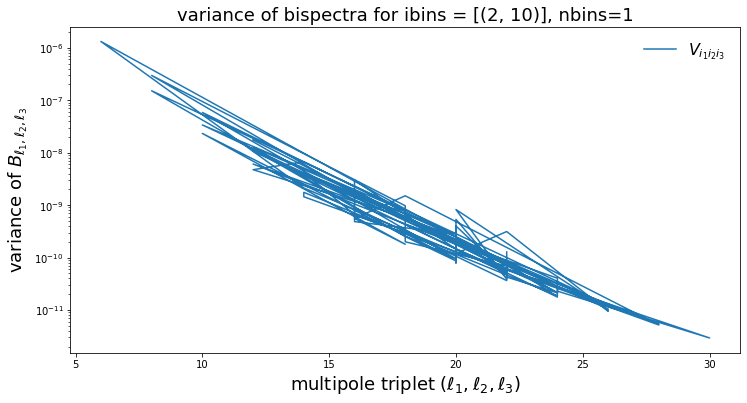

In [29]:
plt.figure(figsize=(12, 6))
# plt.plot(ls, np.std(bls_maps, 0)**2, 'k--', label="gauss")
# plt.plot(ls, np.std(bls_maps_ng, 0)**2, 'r:', label="nongauss")
# plt.plot(ls, (ls+0.0)**(-8), label="$\ell^{-8}$")
# plt.plot(ls, bls_var, label="$V_{\ell_1 \ell_2 \ell_3}$")
plt.plot(plt_sums, binned_var, label="$V_{i_1 i_2 i_3}$")
plt.legend(frameon=False, loc='upper right', fontsize=16)
plt.title(f"variance of bispectra for ibins = [{i1_bin1[0], i1_bin1[-1]}], nbins={nbins}", fontsize=18)
plt.xlabel("multipole triplet $(\ell_1,\ell_2,\ell_3)$", fontsize=18)
plt.ylabel("variance of $B_{\ell_1, \ell_2, \ell_3}$", fontsize=18)
plt.yscale('log')
plt.show()